In [3]:
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df_all = pd.read_pickle('./data/df_all_lemma.pkl')
print(len(df_all))
df_all.head(1)

2524


,comments,description,duration,event,film_date,languages,link,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,transcript,url,views
0,4553.0,Sir Ken Robinson makes an entertaining and pro...,1164.0,TED2006,1.140826e+09,60.0,NaN,Ken Robinson,Ken Robinson: Do schools kill creativity?,1.0,1.151367e+09,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,it been great hasnt it. ive been blown away by...,https://www.ted.com/talks/ken_robinson_says_sc...,47227110.0


In [5]:
docs_all = list(df_all['transcript'])

from nltk.corpus import stopwords

stops_standard = stopwords.words('english')
stops_custom = ['shes','youll','ill','yeah','th','yes','oh',
                'ok','okay','might','ha','mr','bg','ms',
                'mrs','ca','em','da','ted','pm','hey','al']+[re.sub('[^A-Za-z ]+', '', w) for w in stops_standard]
stop_list = list(set(stops_standard + stops_custom))

print(stop_list)

['aren', 'wouldnt', 'shouldn', 'arent', "should've", 'out', 'isn', 'during', 'youve', 'thatll', 'itself', 'mightnt', 'haven', 'that', 'their', 'where', 'down', 'your', 'ted', 'those', "you'd", 'my', 'didn', 'most', 'couldn', 'such', "aren't", 'here', 'ain', 'after', "she's", 'then', 'him', 're', 'bg', 'dont', 'as', "hasn't", 'can', 'shes', 'havent', 'very', 'nor', 'how', 'al', 'these', "mightn't", "isn't", "haven't", 'but', 'won', 'em', 'ours', 's', 'ok', 'you', 'shouldnt', 'didnt', 'not', 'into', 'shan', 'other', 'own', 'no', 'some', 'yourselves', 'i', 'on', 'a', 'both', 'theirs', 'off', 'for', 'it', 'our', 'be', 'an', 'than', 'ill', "you're", 'each', 'against', 'youll', 'did', 'until', 'any', 'his', 'why', 'hers', 'just', "didn't", 'himself', 'them', 'if', 'now', 'themselves', 'whom', 'hey', 'neednt', 'above', 'in', 'should', 'wouldn', 'between', 'she', 'about', 'they', 'yourself', 'da', "don't", "you'll", 'hadn', 'had', 'all', 'youd', 'this', 'with', 'yours', 'her', 'only', 'same', 

In [36]:
docs = docs_all

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 2000
n_components = 50
n_top_words = 10
n_gram = 1
alpha = 0.1
stop_choice= stop_list

max_df = 0.3
min_df = 5
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                                ngram_range=(n_gram,n_gram),
                                max_features=n_features,
                                stop_words=stop_choice)
t0 = time()
tf = tf_vectorizer.fit_transform(docs)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the LDA model
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf features for LDA...
done in 3.163s.

Fitting LDA models with tf features, n_samples=2000 and n_features=2000...
done in 19.229s.

Topics in LDA model:
Topic #0: limb animal force muscle spring frame per video movement surface
Topic #1: energy car oil climate product water fuel carbon city per
Topic #2: south community city environmental development waste economic common park dog
Topic #3: baby mother pregnant mom birth milk awesome born amazing box
Topic #4: united men paper black data per statistic everybody india nice
Topic #5: film movie character camera shot director actor image photograph scene
Topic #6: girl men mother father boy parent war knew night fear
Topic #7: card la audience king queen fold club member ah seven
Topic #8: data information internet medium online phone network computer social government
Topic #9: cell cancer patient disease drug blood doctor medical treatment heart
Topic #10: choice decision choose option puzzle alternative decide consequence o

In [37]:
X = lda.fit_transform(tf)


In [14]:
# X[134].argmax()

In [15]:
# np.savetxt('./data/lda_data.tsv', X, delimiter='\t',newline='\n')
# Xlabel = list(df_all.title)
# with open('./data/lda_meta.tsv', 'w') as file:
#     for label in Xlabel:
#         file.write(label+'\n')

In [42]:
def save_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words

tf_feature_names = tf_vectorizer.get_feature_names()
n_top_words = 10
LDA_top_words = save_top_words(lda, tf_feature_names, n_top_words)

In [45]:
df = pd.DataFrame(LDA_top_words)
df.head()
# df.to_pickle('./data/LDA_top_words.pkl')

### Find related talks

In [9]:
import sklearn.neighbors.kd_tree as kdtree

In [38]:
def match_score(list1, list2):
    m = len(list1)
    score = 0
    matches = 0
    for title in list2:
        if title in list1:
            score += m - list1.index(title)
            matches += 1
    return (score, matches)

In [39]:
tree = kdtree.KDTree(X, leaf_size=10) 
scores = []
matches = []
for N in range(2467):
    # N = 1
    if N%100==0:
        print(N)
    dist, ind = tree.query([X[N]], k=20)  
    list1 = []
    for i in ind[0]:
        list1.append(df_all.iloc[i].title)
    list2 = []
    df_related = pd.DataFrame(eval(df_all.iloc[N]['related_talks']))
    for k in range(len(df_related)):
        items = list(df_all[df_all['title']==df_related.iloc[k]['title']].title)
        if len(items)>0:
            list2.append(items[0])
    scores.append(match_score(list1,list2)[0])
    matches.append(match_score(list1,list2)[1])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


In [40]:
sum(scores)/2467

12.407782732063234

In [41]:
sum(matches)/2467

1.0575597892176734

In [64]:
tree = kdtree.KDTree(X, leaf_size=10) 
N = 2060
dist, ind = tree.query([X[N]], k=20)  
for i in ind[0]:
    print(i,'\t',df_all.iloc[i].title)
#     print(i,'\t',df_all.iloc[i].views)
#     print(df_all.iloc[i].tags)

2060 	 My year of saying yes to everything
372 	 Fiddling in reel time
2356 	 On tennis, love and motherhood
2024 	 A hilarious celebration of lifelong female friendship
1317 	 Please don't take my Air Jordans
1527 	 An ode to envy
1912 	 One woman, five characters, and a sex lesson from the future
1469 	 The orchestra in my mouth
795 	 Let's talk parenting taboos
314 	 A story of mixed emoticons
2324 	 What young women believe about their own sexual pleasure
338 	 Do the green thing
241 	 The transformative power of classical music
2107 	 Wisdom from great writers on every year of life
2259 	 What I learned from 100 days of rejection
2261 	 Do kids think of sperm donors as family?
1116 	 Everyday moments, caught in time
1931 	 When to take a stand -- and when to let it go
1905 	 Gorgeous portraits of the world's vanishing people
1920 	 Confessions of a bad feminist


In [65]:
df_related = pd.DataFrame(eval(df_all.iloc[N]['related_talks']))
for k in range(len(df_related)):
    print(list(df_all[df_all['title']==df_related.iloc[k]['title']].title))
#     print(df_all[df_all['title']==df_related.iloc[k]['title']].views)
#     print(list(df_all[df_all['title']==df_related.iloc[k]['title']].tags))

['Your elusive creative genius']
['How to use data to make a hit TV show']
['Should you live for your résumé ... or your eulogy?']
['How to find a wonderful idea']
['Fashion and creativity']
['Play is more than just fun']


In [12]:
# print(docs_all[395])

### Clustering using KMeans

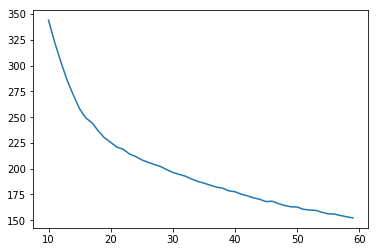

In [46]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import cluster

# n_clusters = 50

ward = cluster.AgglomerativeClustering(
    n_clusters=n_clusters, linkage='ward',
    connectivity=connectivity)
# spectral = cluster.SpectralClustering(
#     n_clusters=n_clusters, eigen_solver='arpack',
#     affinity="nearest_neighbors")
# Xp = spectral.fit_predict(X)
# dbscan = cluster.DBSCAN(eps=params['eps'])

# km = KMeans(n_clusters=50)
# Xt = km.fit_transform(X)

# mu_docs = km.cluster_centers_
# plt.plot(mu_docs.transpose())

# silhouette_score(X, km.labels_, metric='euclidean')

sil_scores = []
iner_scores = []
ks = range(10,60)
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sil_scores.append(silhouette_score(X, km.labels_, metric='euclidean'))
    iner_scores.append(km.inertia_)

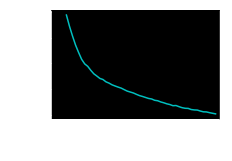

In [54]:
plt.figure(figsize=(3,2))
plt.plot(ks,iner_scores,'c')
plt.rcParams['axes.facecolor'] = 'black'

ax = plt.gca()
ax.set_xlabel('# OF CLUSTERS', fontsize=14, fontweight='bold')
ax.set_ylabel('INERTIA', fontsize=14, fontweight='bold')
ax.set_xlim([5,60])
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('k')
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('k')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

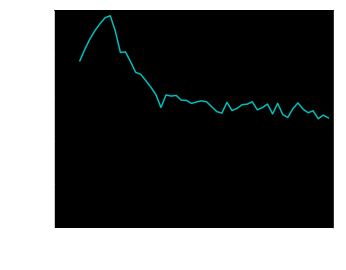

In [59]:
plt.figure(figsize=(5,4))
plt.plot(ks,sil_scores,'c')
plt.rcParams['axes.facecolor'] = 'black'

ax = plt.gca()
ax.set_xlabel('# OF CLUSTERS', fontsize=14, fontweight='bold')
ax.set_ylabel('SILHOUETTE', fontsize=14, fontweight='bold')
ax.set_xlim([5,60])
ax.set_ylim([0.05,0.3])

ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('k')
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('k')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

In [505]:
tree = kdtree.KDTree(Xt, leaf_size=10) 
# N = 1346
dist, ind = tree.query([Xt[N]], k=10)  
for i in ind[0]:
    print(i,'\t',df_all.iloc[i].title)
#     print(i,'\t',df_all.iloc[i].views)
#     print(df_all.iloc[i].tags)

1599 	 Love -- you're doing it wrong
2343 	 3 ways to plan for the (very) long term
2085 	 How to get back to work after a career break
1395 	 What makes us feel good about our work?
1135 	 How I beat a patent troll
1872 	 How equal do we want the world to be? You'd be surprised
1821 	 The danger of hiding who you are
1870 	 5 ways to kill your dreams
1566 	 The $80 prosthetic knee that's changing lives
609 	 Plug into your hard-wired happiness


In [506]:
df_all.iloc[2343].transcript

'and theyd say great. and ive been seeing that time horizon get shorter and shorter and shorter so much so that i met with a ceo two month ago and i said we started our initial conversation. he go i love what you do. i want to talk about the next six month. we have a lot of problem that we are facing. these are civilizationalscale problem. the issue though is we cant solve them using the mental model that we use right now to try and solve these problem. yes a lot of great technical work is being done but there is a problem that we need to solve for a priori before if we want to really move the needle on those big problem. shorttermism. right. there no march. there no bracelet. there no petition that you can sign to be against shorttermism. i tried to put one up and no one signed. it wa weird. but it prevents u from doing so much. shorttermism for many reason ha pervaded every nook and cranny of our reality. i just want you to take a second and just think about an issue that youre think